# 📘 Comic Spoiler Detection Demo (Colab Notebook)

## 🛠️ STEP 1: Install Required Packages


In [1]:
!pip install transformers ultralytics xgboost deepface scikit-learn opencv-python-headless pytesseract


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━

## 📁 STEP 2: Clone the GitHub Repository


In [2]:
!git clone https://github.com/djcode0718/ComicSpoilerDetection.git
%cd ComicSpoilerDetection

Cloning into 'ComicSpoilerDetection'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 34 (delta 7), reused 31 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 10.50 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/ComicSpoilerDetection


## 📦 STEP 3: Load Models

In [3]:
import cv2
import numpy as np
import pandas as pd
import pytesseract
from transformers import pipeline
from ultralytics import YOLO
import joblib
from xgboost import XGBClassifier
from deepface.DeepFace import represent
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cosine


# Set Tesseract path for Colab (Skip if using hosted runtime)
!apt install tesseract-ocr -y
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

# Load HuggingFace Pipelines
caption_generator = pipeline("summarization", model="facebook/bart-large-cnn")
genre_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Load local models (if uploaded to Colab)
character_detector = YOLO("models/yolov8_comic_characters_detect.pt")
xgboost_model = joblib.load("models/xgboost_spoiler_classifier.pkl")
tfidf_vectorizer = joblib.load("models/tfidf_vectorizer.pkl")
genre_encoder = joblib.load("models/genre_encoder.pkl")

# Define genre labels
genre_labels = ["Sports", "Crime", "Action", "Fantasy", "Sci-Fi", "Romance", "Horror", "Comedy", "Drama", "Mystery", "Superhero"]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
25-06-18 20:00:46 - Directory /root/.deepface has been created
25-06-18 20:00:46 - Directory /root/.deepface/weights has been created
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


## Helper functions


In [4]:
# 🔹 Feature Extraction Functions
def extract_text_from_image(image_path):
    """Extract text from an image using Tesseract OCR."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return ""

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray)
    return text.strip()

def generate_caption(text):
    """Generate a short caption using BART summarization."""
    if not text or text.strip() == "":
        return "No caption available"

    try:
        summary = caption_generator(text, max_length=50, min_length=10, do_sample=False)
        return summary[0]['summary_text']
    except Exception as e:
        print(f"Error summarizing text: {e}")
        return "Error generating caption"

def predict_genre(text):
    """Predict comic genre using BART-based zero-shot classification."""
    if not text.strip():
        return "Unknown"

    result = genre_classifier(text, genre_labels)
    predicted_genre = result["labels"][0]

    # Ensure predicted genre is within allowed genres
    if predicted_genre not in genre_labels:
        predicted_genre = "Unknown"

    return predicted_genre

def get_face_embedding(face):
    """Extract face embeddings using DeepFace."""
    try:
        face_embedding = represent(face, model_name="Facenet", enforce_detection=False)
        return face_embedding[0]['embedding']
    except Exception as e:
        print(f"Error extracting face embedding: {e}")
        return None

def detect_unique_characters(image_path):
    """Detect unique characters in a comic page image."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not read image {image_path}")
        return 0

    results = character_detector(image)
    face_embeddings = []

    # Extract detected characters
    for result in results:
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box)
            face = image[y1:y2, x1:x2]
            if face.size == 0:
                continue

            embedding = get_face_embedding(face)
            if embedding is not None:
                face_embeddings.append(embedding)

    if not face_embeddings:
        print("Unique characters detected: 0")
        return 0

    # Cluster face embeddings to identify unique characters
    clustering = DBSCAN(metric=cosine, eps=0.5, min_samples=1)
    labels = clustering.fit_predict(face_embeddings)

    unique_characters = len(set(labels))
    print(f"Unique characters detected: {unique_characters}")
    return unique_characters

# 🔹 Spoiler Prediction Function
def predict_spoiler(image_path):
    """Predict whether a comic panel contains a spoiler."""
    print(f"Processing image: {image_path}...")

    # Step 1: Extract text
    extracted_text = extract_text_from_image(image_path)
    print(f"Extracted Text: {extracted_text}")

    # Step 2: Generate Caption
    caption = generate_caption(extracted_text)
    print(f"Generated Caption: {caption}")

    # Step 3: Predict Genre
    genre = predict_genre(extracted_text)
    print(f"Predicted Genre: {genre}")

    # Step 4: Count Unique Characters
    unique_character_count = detect_unique_characters(image_path)
    print(f"Unique Character Count: {unique_character_count}")

    # Step 5: Encode Genre
    if genre in genre_encoder.classes_:
        genre_encoded = genre_encoder.transform([genre])[0]
    else:
        genre_encoded = -1  # Assign a default value for unknown genres

    # Step 6: Convert Caption to TF-IDF Features
    caption_features = tfidf_vectorizer.transform([caption]).toarray()  # Shape (1, 500)

    # Step 7: Fix Dimension Mismatch
    numeric_features = np.array([[unique_character_count, genre_encoded]])  # Shape (1, 2)
    X_input = np.hstack((numeric_features, caption_features))  # Shape (1, 502)

    # Step 8: Ensure Correct Shape Before Prediction
    X_input = np.array(X_input).reshape(1, -1)  # Ensure 2D array shape (1, 502)

    # Step 9: Predict Spoiler
    prediction = xgboost_model.predict(X_input)[0]

    # Step 10: Interpret Prediction
    label_mapping = {0: "Unknown", 1: "🟩 Non-Spoiler", 2: "🟥 Spoiler"}
    print(label_mapping.get(prediction, "Unknown"))

## 🖼️ STEP 4: View a Test Image

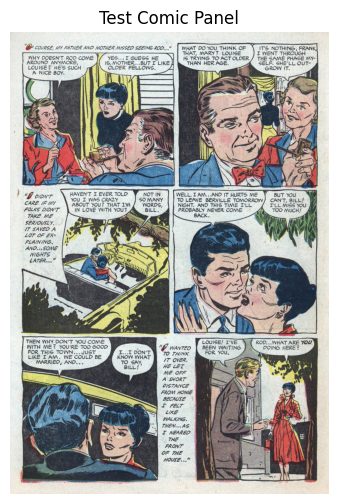

In [6]:
import matplotlib.pyplot as plt
img_path = "images/0adacd53-c788-470a-8c38-b68449d504a9.jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Test Comic Panel")
plt.axis("off")
plt.show()

## 🧠 STEP 5: Predict the spoiler

In [7]:
predict_spoiler(img_path)



Processing image: images/0adacd53-c788-470a-8c38-b68449d504a9.jpg...
Extracted Text: ‘@ COURSE, MY FATHER AND MOTHER MISSED SEEING ROD...”

     
  
  
 

AROUND ANYMORE,
LOUISE? HE'S SUCH
A NICE Boy.

"“G o1oN'T
CARE /F MY
FOLKS DION'T
TAKE ME
SERIOUSLY,
17 SAVED A
LOT OF EX-
PLAINING.
AND... SOME
MGHTS
LATER...”

THEN WHY DON'T YOU COME
WITH ME<¢ YOU'RE TOO GOOD
FOR_THIS TOWN... JUST
LIKE IT AM. WE COULD BE

MARRIED, AND...

 

   

WHY DOESN'T ROD COME }

HAVEN'T I EVER TOLD
YOU I WAS CRAZY

ABOUT YOU? THAT I'M
IN LOVE WITH YOU 4

  

WHAT DO YOU THINK OF

THAT, MARY? LOUISE

IS TRYING TO ACT OLDER
THAN HER AGE.

IT'S NOTHING, FRAN
I WENT THROUGH
THE SAME PHASE MY-
SELF. SHE'LL OUT-
GROW IT.

    

YES... I GUESS HE
IS, MOTHER...BUT I BIR

OLDER FELLOWS.

        
  

   
  

     
 

NIGHT. AND THIS TIME I'LL
PROBABLY NEVER COME
BACK.

    
   
 
 
 
 
 
 
 
 

 

ROD...WHAT ARE YOU
DOING HERE?

LOUISE! I'VE *
BEEN WAITING

"ff! WANTED Ben We

70 THINK
/T OVER.
HE LET
ME OFF
A SHOR

Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:01<00:00, 59.6MB/s]


Unique characters detected: 2
Unique Character Count: 2
🟩 Non-Spoiler


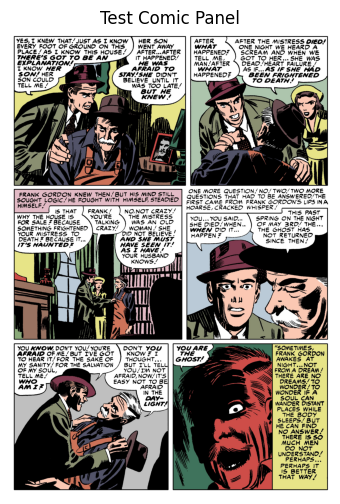

In [8]:
import matplotlib.pyplot as plt
img_path = "images/002a6441-5424-4f66-8998-d74a052b92ec (1).jpg"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title("Test Comic Panel")
plt.axis("off")
plt.show()

In [9]:
predict_spoiler(img_path)

Processing image: images/002a6441-5424-4f66-8998-d74a052b92ec (1).jpg...
Extracted Text: YES, I KNEW THAT./ JUST AS I KNOW \ HER SON AFTER THE MISTRESS OLED!
EVERY FOOT OF GROUND ON THIS. ] WENT AWAY WHAT ONE NIGHT WE HEARD A
/ / AFTER...AFTER | | HAPPENEDZ

SCREAM AND WHEN WE
EAN g IT HAPPENED’ TELL ME, GOT TO HER... SHE WAS
EXPLANATION!

. HE WAS MAN/AFTER DEAD./HEART FAILURE ,/
T KNOW WER WHAT AS IF...AS IF SHE HA
SON/ HER

STAY/SHE DION'T | | HAPPENEDZ BEEN FRIGHTENED
SON COULD BELIEVE UNTIL IT TO DEATH!
TELL ME ,/ =~ WAS TOO LATE/

MORE QUESTION! NO/ TWO’ TWO MORE
FRANK GORDON KNEW THEN’ BUT His MIND STILL | SIE-TIONe Suar HAD 10 BE ANSWEREO. THE
SOUGHT LOGIC THE FOUGHT WITH HIMSELF STEAPIED | FigsT CAME FROM FRANK GORDON’S LIPS INA

THE MISTRESS A Pear
YOU... YOU SAID... \ SPRING ON THE NI
FOR SALE 7 BECAUSE WAS AN OLD OU as TOU

: SHE DIED’ WHEN.. | OF MAY 3RD/ THE...

WOMAN | SHE, | | WHEN OID IT... THE GHOST HAS
YOUR MISTRESS TO DID NOT BELIEVE : HAPPEN 7 NOT RETURNED
DEATH 7 